In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
img_id = "CA184632V0343"
save_image = False
overwrite = False

output_fld = "/data_1/ATM/data_1/georef"

<h4>Check if the image is already geo-referenced</h4>


In [3]:
import pandas as pd

# define the path to processed images
csv_path = output_fld + "/img_processed_images.csv"

if save_image:
    # load processed images as dict
    processed_images = pd.read_csv(csv_path, delimiter=";")
    processed_images.set_index('id', inplace=True)
    processed_images = processed_images.to_dict(orient='index')

    # check if image is already geo-referenced
    if processed_images.get(img_id, {}).get('status') == "georeferenced" and not overwrite:
        print(f"{img_id} already processed")
        exit()

<h4>Find overlapping images</h4>

In [4]:
import os
import glob
import src.base.find_overlapping_images as foi

# define path to the already geo-referenced images
path_satellite_fld = "/data_1/ATM/data_1/georef/sat"

# get the filenames of all tiffs in this folder
# List all .tif files in the folder
tif_files = glob.glob(os.path.join(path_satellite_fld, '*.tif'))
tif_files = [os.path.splitext(os.path.basename(file))[0] for file in tif_files]

# add the image_id to the list of tif_files
tif_files.append(img_id)

# find overlapping images for the image to geo-reference just based on the image id
overlapping_images = foi.find_overlapping_images(tif_files, working_modes=["ids"], important_id=img_id)

print(overlapping_images)

{'CA184632V0343': ['CA184632V0342', 'CA184632V0341']}


<h4>Load the images</h4>

In [5]:
import src.load.load_image as ld

# load image to geo-reference
image = ld.load_image(img_id)

# list of already geo-referenced images
georeferenced_images = []

# iterate through overlapping images
for ov_img_id in overlapping_images[img_id]:

    # load the geo-referenced image
    georef_img = ld.load_image(ov_img_id)
    georeferenced_images.append(georef_img)

<h4>Load the transforms</h4>

In [6]:
import src.load.load_transform as lt

fld_sat_transforms = "/data_1/ATM/data_1/georef/sat"

georeferenced_transforms = []

for ov_img_id in overlapping_images[img_id]:

    # load the transform
    transform = lt.load_transform(fld_sat_transforms + "/" + ov_img_id + "_transform.txt")
    georeferenced_transforms.append(transform)

<h4>Create masks</h4>

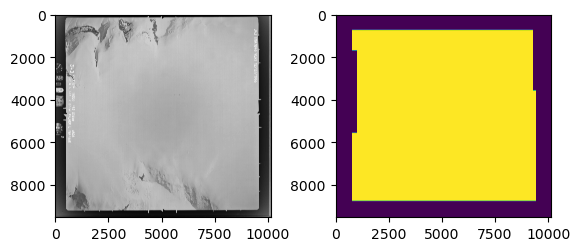

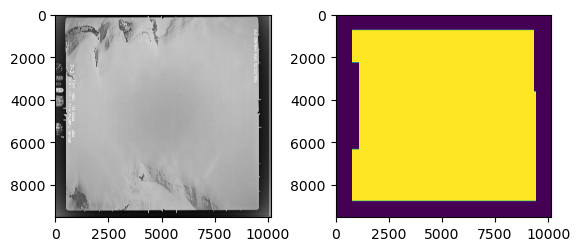

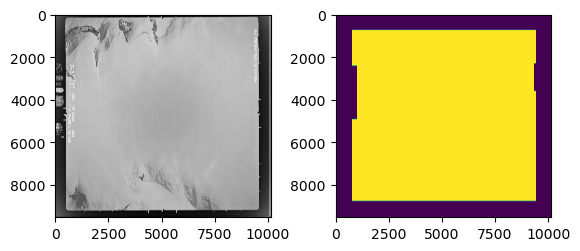

In [7]:
import src.base.connect_to_database as ctd
import src.base.create_mask as cm

import src.display.display_images as di

conn = ctd.establish_connection()

sql_string_fid_marks = f"SELECT * FROM images_fid_points WHERE image_id='{img_id}'"
data_fid_marks = ctd.execute_sql(sql_string_fid_marks, conn)

ids = [img_id] + overlapping_images[img_id]

georeferenced_masks = []

for i, _id in reversed(list(enumerate(ids))):

    sql_string_fid_marks = f"SELECT * FROM images_fid_points WHERE image_id='{_id}'"
    data_fid_marks = ctd.execute_sql(sql_string_fid_marks, conn)

    sql_string_extracted = f"SELECT * FROM images_extracted WHERE image_id='{_id}'"
    data_extracted = ctd.execute_sql(sql_string_extracted, conn)

    # Get the fid marks for the specific image_id
    fid_marks_row = data_fid_marks.loc[data_fid_marks['image_id'] == _id].squeeze()

    # Create fid mark dict using dictionary comprehension
    fid_dict = {i: (fid_marks_row[f'fid_mark_{i}_x'], fid_marks_row[f'fid_mark_{i}_y']) for i in range(1, 5)}

    # get the text boxes of the image
    text_string = data_extracted.loc[data_extracted['image_id'] == _id]['text_bbox'].iloc[0]

    if len(text_string) > 0 and "[" not in text_string:
        text_string = "[" + text_string + "]"

    # create text-boxes list
    text_boxes = [list(group) for group in eval(text_string.replace(";", ","))]

    # load the mask
    mask = cm.create_mask(image, fid_dict, text_boxes, min_border_width=750)

    di.display_images([image, mask])

    if i > 0:
        georeferenced_masks.append(mask)


2 images are used for the geo-referencing
168 outliers removed with RANSAC
2814 tie points found between the input image and the 1th geo-referenced image


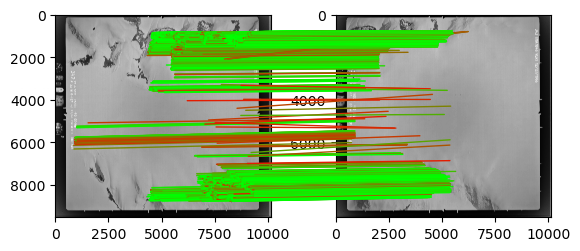

35 outliers removed with RANSAC
409 tie points found between the input image and the 2th geo-referenced image


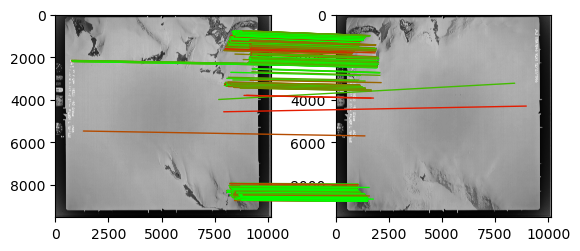

[ 8.48342576e-01 -2.54108770e-01 -1.92574726e+06 -3.49938503e-01
 -7.42745737e-01  7.53444678e+05  0.00000000e+00  0.00000000e+00
  1.00000000e+00]


In [8]:
import src.georef.georef_img as gi

georefImg = gi.GeorefImage(enhance_image=True, enhance_georef_images=True)

print(f"{len(georeferenced_images)} images are used for the geo-referencing")

transform, residuals, tps, conf = georefImg.georeference(image, georeferenced_images, georeferenced_transforms, mask=mask, georeferenced_masks=georeferenced_masks)

print(transform)

<h4>Verify the geo-referencing</h4>

In [9]:
import src.base.modify_csv as mc
import src.georef.snippets.verify_image_geometry as vig

transform = transform.flatten()

valid_geometry, reason = vig.verify_image_geometry(image, transform)

if valid_geometry:
    print("Valid geometry:", valid_geometry)
    if save_image:
        processed_images[img_id] = {"method": "img", "status": "georeferenced",
                                    "reason": "", "time": ""}
        mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
else:
    print("Invalid because of:", reason)
    if save_image:
        processed_images[img_id] = {"method": "img", "status": "invalid",
                                    "reason": reason, "time": ""}
        mc.modify_csv(csv_path, img_id, "add", processed_images[img_id], overwrite=True)
        exit()

Invalid because of: length:19.67


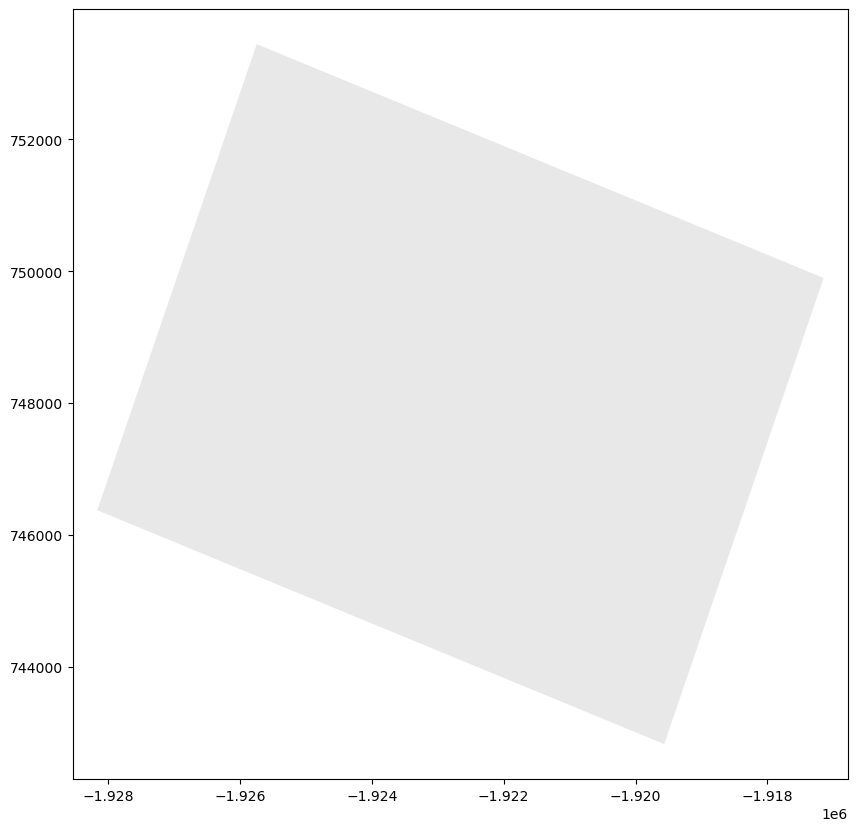

In [13]:
import src.display.display_shapes as ds
import src.georef.snippets.convert_image_to_footprint as citf

# create a footprint for this image
footprint = citf.convert_image_to_footprint(image, transform)

ds.display_shapes([footprint])

<h4>Save the data</h4>

In [16]:
import numpy as np
import pandas as pd

import src.base.connect_to_database as ctd

import src.georef.snippets.apply_transform as af
import src.georef.snippets.convert_image_to_footprint as citf

import src.export.export_geometry as eg

# merge tps and conf
tps_conf = np.concatenate([tps, conf.reshape(-1, 1), residuals.reshape((-1, 1))], axis=1)

# define path to shape file
path_shp_file = f"{output_fld}/img.shp"

if save_image:
    # apply the transform and save geo-referenced tiff
    af.apply_transform(image, transform, f"{output_fld}/img/{img_id}.tif")

    # save transform and points
    np.savetxt(f"{output_fld}/img/{img_id}_transform.txt", transform.reshape(3,3), fmt='%.5f')
    np.savetxt(f"{output_fld}/img/{img_id}_points.txt", tps_conf, fmt=['%i', '%i', '%.2f', '%.2f', '%.3f', '%.3f'])

# create a footprint for this image
footprint = citf.convert_image_to_footprint(image, transform)

# calculate average values
# noinspection PyTypeChecker
conf_mean: float = np.mean(conf)
# noinspection PyTypeChecker
residuals_mean: float = np.mean(residuals)

# get the month
conn = ctd.establish_connection()
sql_string = f"SELECT * FROM images WHERE image_id='{img_id}'"
data = ctd.execute_sql(sql_string, conn)
month = data.iloc[0]['date_month']

# define attributes
attributes = {
    'image_id': img_id,
    'month': month,
    'num_tps': tps.shape[0],
    'avg_conf': round(conf_mean, 3),
    'avg_resi': round(residuals_mean, 3),
}

attributes = pd.DataFrame.from_dict(attributes, orient='index').T

if save_image:
    # save footprint to shp file
    eg.export_geometry(footprint, path_shp_file,
                       attributes=attributes, key_field="image_id",
                       overwrite_file=False,
                       overwrite_entry=True, attach=True)

    print(f"{img_id} successfully saved")


In [22]:
from scipy.optimize import minimize

def objective_function_affine(params, tps):
    # Unpack affine transformation parameters
    a, b, tx, d, e, ty = params

    # Calculate alignment error
    alignment_error = 0
    for tp in tps:
        x1, y1, x2, y2 = tp
        # Apply affine transformation
        x1_prime = a * x1 + b * y1 + tx
        y1_prime = d * x1 + e * y1 + ty

        # Calculate distance
        alignment_error += np.sqrt((x1_prime - x2)**2 + (y1_prime - y2)**2)

    # Optionally add penalty for deviation from expected scale/rotation

    return alignment_error

initial_guess_affine = transform[:6]

# Optimize affine parameters
result = minimize(objective_function_affine, initial_guess_affine, args=(tps,))
result = np.append(result.x, [0, 0, 1])
print(transform)
print(result)
print(transform.shape, result.shape)


af.apply_transform(image, result, f"{output_fld}/test/{img_id}_optimized.tif")


[ 8.48342576e-01 -2.54108770e-01 -1.92574726e+06 -3.49938503e-01
 -7.42745737e-01  7.53444678e+05  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
[-1.10233356e+00 -2.57357013e-01 -1.92573940e+06 -7.91750799e-02
 -1.20321743e+00  7.53449381e+05  0.00000000e+00  0.00000000e+00
  1.00000000e+00]
(9,) (9,)
